# Mnożenie macierzy rzadkich w formatach CSR i CSC

**Maciej Skoczeń**, **Kacper Kafara**

grupa wtorek (A) 17:50

## Środowisko obliczeniowe

Procesor: Intel i7-9750H @ 2,6 GHz; 6 rdzeni fizycznych (12 log.)

## Importy & typy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import subprocess
import matplotlib.pyplot as plt
import platform

from timeit import default_timer
from math import sqrt

Array = np.ndarray

## Funkcje pomocnicze

In [2]:
class Timer(object):
    def __init__(self):
        self._start_time = None
        self._stop_time = None

    def start(self):
        self._start_time = default_timer()

    def stop(self):
        self._stop_time = default_timer()

    @property
    def elapsed(self, val = None):
        if self._stop_time is None or self._start_time is None:
            return None
        elapsed = self._stop_time - self._start_time
        return elapsed

# mock impl
def is_int(value) -> bool:
    as_int = int(value)
    return value == as_int

###  Wczytywanie macierzy

wygenerowanej za pomocą dostarczonego skryptu `mass_matrix`, przepisanego do C++.

In [3]:
def input_matrix(octave_matrix, n, m, q=1):
    result = np.zeros((n*q, m*q), dtype=np.double)
    
    for elem in octave_matrix:
        m = re.match(r"\s*\((\d+),\s*(\d+)\)\s*->\s*(\d+\.\d+)\s*", elem)
        if m is not None:
            x, y, value = m.groups()
        elif len(elem) > 0:
            coord, value = elem.strip().split(' -> ')
            value = float(value)
            x, y = coord.split(',')
            x, y = x[1:], y.strip()[:-1]
        else:
            continue
        
        for i in range(q):
            for j in range(q):
                result[i*n + int(x) - 1, j*n + int(y) - 1] = float(value)
        
    return result

In [4]:
def load_octave_matrix(filename):
    with open(filename, "r") as file:
        return file.readlines()

In [5]:
data_dir = "../../output"

def resolve_path(matrix_type, width, height = None, generate = False):
    if height is None: height = width
    path = f"{data_dir}/{matrix_type}-{width}x{height}.txt"
    if os.path.isfile(path): return path
    elif not generate:
        raise FileNotFoundError(f"Matrix file {path} was not found in data dir.")
    else: 
        if platform.system() == "Windows":
            raise FileNotFoundError(f"Matrix file {path} was not found in data dir.\
                Automated generation is not supported on your platform: {platform.system()}.")

        if width != height:
            raise ValueError("Can only generate square matrix")
            
        generate_matrix(matrix_type, width)
        
        if os.path.isfile(path): return path
        else:
            print(path)
            raise RuntimeError("Failed to generate matrix")

In [6]:
def resolve_matrix(matrix_type, n, m, q = 1, generate = False):
    return input_matrix(
        load_octave_matrix(resolve_path(matrix_type, n, m, generate = generate)), n, m, q)

In [7]:
def generate_matrix(matrix_type, rank):
    if matrix_type not in {'iga', 'fem'}:
        raise ValueError(f"Invalid matrix type: {matrix_type}")
        
    if rank < 16 or not is_int(sqrt(rank)):
        raise ValueError(f"Invalid matrix rank: {rank}. Must be >= 16 and sqrt(rank) must be of type integer.")
        
    rank_root = int(sqrt(rank))
    
    if matrix_type == 'fem':
        for p in range(2, 5):
            double_nxx = rank_root - p + 1
            if double_nxx % 2 == 0 and double_nxx // 2 >= 2:
                nxx = double_nxx // 2
                pxx = p
                break
        else:
            raise RuntimeError(f"Failed to determine nxx, pxx for rank: {rank}")
    else:
        for p in range(2, 5):
            nxx = rank_root - p
            if nxx >= 2:
                pxx = p
                break
        else:
            raise RuntimeError(f"Failed to determine nxx, pxx for rank: {rank}")
    
    cwd = os.getcwd()
    os.chdir(os.getenv('SCRIPTS_DIR'))
    !./generate-matrix.sh cpp {matrix_type} {nxx} {pxx} 0
    os.chdir(cwd)

## Generowanie macierzy

Zgodnie z poleceniem, będziemy mnożyć swoje macierze z laboratorium 1, czyli IGA * FEM.    
Zostały one wygenerowane skryptem mass_matrix z parametrami:
 - IGA: riga=0 nxx=30 pxx=2 rxx=0
 - FEM: riga=1 nxx=15 pxx=3 rxx=0   
 
Ostatecznie otrzymaliśmy macierze o wymiarach $1024x1024$.

In [8]:
n = 1024 # liczba wierszy i kolumn macierzy A i B
A = resolve_matrix('iga', n, n, generate=True)
B = resolve_matrix('fem', n, n, generate=True)

riga=0 (iga)
nxx=30
pxx=2
rxx=0
riga=1 (fem)
nxx=15
pxx=3
rxx=0


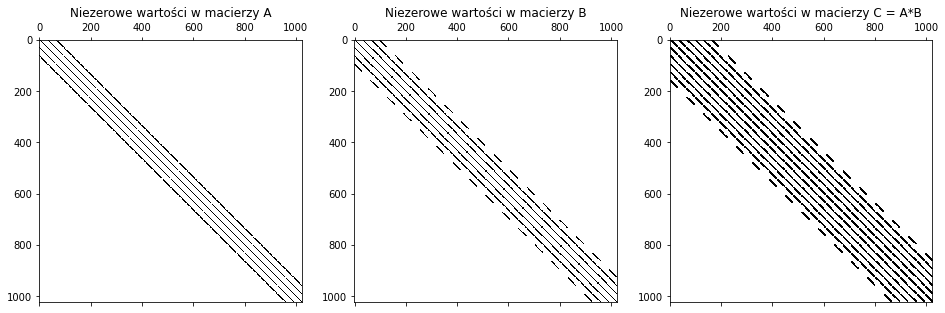

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,16))
ax1.set_title('Niezerowe wartości w macierzy A')
ax1.spy(A)
ax2.set_title('Niezerowe wartości w macierzy B')
ax2.spy(B)
ax3.set_title('Niezerowe wartości w macierzy C = A*B')
ax3.spy(A@B)
plt.show()

## Mnożenie macierzy algorytmem z laboratorium 1

Najkrótsze czasy dawała wtedy kolejność pętli jip.

In [10]:
def dot_product(vect1, vect2, k):
    result = 0
    for p in range(k):
        result += vect1[p]*vect2[p]
    return result

def jip_dense_mul(A, B, n, m, k, timer = None):
    C = np.zeros((n, m))
    if timer: timer.start()
    for j in range(m):
        for i in range(n):
            C[i,j] = dot_product(A[i, 0:k], B[0:k, j], k)
    if timer: timer.stop()
    return C

In [11]:
r = 5
timer = Timer()
times = [0]*r
for i in range(r):
    C = jip_dense_mul(A, B, n, n, n, timer)
    times[i] = timer.elapsed
    
print(f'Czas mnożenia macierzy gęstych: {sum(times)/r:.5f}s')

Czas mnożenia macierzy gęstych: 394.82665s


## Konwersja do macierzy rzadkich

Przyjmujemy, że macierze są kwadratowe. Następnie idziemy po macierzy gęstej wierszami dla CSR, a kolumnami dla CSC. Wypełniamy tablice reprezentacji macierzy rzadkich jedynie dla wartości niezerowych.

In [12]:
class CSRMatrix:
    def __init__(self, matrix = None):
        self.NNZ = 0 # liczba niezerowych elementów
        self.N = 0 # wysokość/szerokość macierzy
        self.icl = [] # kolumna dla danej wartości
        self.val = [] # wartości niezerowe
        self.rowptr = [] # indeksy początków kolumn
        if matrix is not None:
            self.from_dense(matrix)
    
    def from_dense(self, matrix_dense):
        self.N = matrix_dense.shape[0]
        for i in range(self.N): # wiersze
            self.rowptr.append(self.NNZ) # nowy wiersz
            for j in range(self.N): # kolumny
                if matrix_dense[i,j] != 0:
                    self.NNZ += 1
                    self.icl.append(j)
                    self.val.append(matrix_dense[i,j])
                    
        self.rowptr.append(self.NNZ)
    

class CSCMatrix:
    def __init__(self, matrix = None):
        self.NNZ = 0
        self.N = 0
        self.irn = []
        self.val = []
        self.colptr = []
        if matrix is not None:
            self.from_dense(matrix)
    
    def from_dense(self, matrix_dense):
        self.N = matrix_dense.shape[0]
        for j in range(self.N): # kolumny
            self.colptr.append(self.NNZ) # nowa kolumna
            for i in range(self.N): # wiersze
                if matrix_dense[i,j] != 0:
                    self.NNZ += 1
                    self.irn.append(i)
                    self.val.append(matrix_dense[i,j])
                    
        self.colptr.append(self.NNZ)

In [13]:
A_sparse = CSRMatrix(A)
B_sparse = CSCMatrix(B)

## Mnożenie macierzy CSR * CSC

Kolejność pętli zachowujemy taką, jak dla mnożenia macierzy gęstych, czyli jip. Nastąpiła tutaj modyfikacja dwóch wewnętrznych pętli, gdzie zamiast przechodzić po wszystkich możliwych indeksach, skaczemy po elementach i porównujemy ze sobą indeksy w wierszu macierzy A oraz kolumnie macierzy B. Mnożenie jest wymagane jedynie dla elementów gdzie ten indeks jest równy, w pozostałych przypadkach mnoży się przez 0, co naturalnie daje również taki wynik i można takie przypadki bezproblemowo pomijać.

In [14]:
def csr_csc_mul(
    A: CSRMatrix, 
    B: CSCMatrix, 
    timer: Timer = None,
    sparse_result: bool = False # wynik w postaci macierzy CSR zamiast gęstej
):
    n = A.N
    if sparse_result:
        C = CSCMatrix()
        C.N = n
    else:
        C = np.zeros((n, n))
        
    if timer: timer.start()
    
    for j in range(n): # kolumny
        if sparse_result:
            C.colptr.append(C.NNZ)
        i = 0 # wiersz
        A_iter = 0 # iterator po tablicach icl oraz val macierzy A
        while True: # pętla po wierszach
            if A_iter == A.NNZ or i == n: # koniec macierzy A, zmiana kolumny
                break
            
            B_iter = B.colptr[j] # iterator po tablicach irn oraz val macierzy B
            tmp_result = 0
            while True: # pętla po elementach w wierszu/kolumnie macierzy A/B
                if A.rowptr[i + 1] <= A_iter or B.colptr[j + 1] <= B_iter: # koniec iteratora, zmiana wiersza
                    i += 1
                    A_iter = A.rowptr[i]
                    break
                if A.icl[A_iter] == B.irn[B_iter]: # elementy w wierszu/kolumnie macierzy A/B mają ten sam indeks
                    tmp_result += A.val[A_iter] * B.val[B_iter]
                    A_iter += 1
                    B_iter += 1
                elif A.icl[A_iter] < B.irn[B_iter]:
                    A_iter += 1
                else:
                    B_iter += 1
                    
            if tmp_result != 0:
                if sparse_result:
                    C.irn.append(i - 1)
                    C.val.append(tmp_result)
                    C.NNZ += 1
                else:
                    C[i - 1,j] = tmp_result
                
    if timer: timer.stop()
    return C

In [15]:
r = 5
timer = Timer()
times = [0]*r
for i in range(r):
    C = csr_csc_mul(A_sparse, B_sparse, timer)
    times[i] = timer.elapsed
    
print(f'Czas mnożenia macierzy rzadkich: {sum(times)/r:.5f}s')

Czas mnożenia macierzy rzadkich: 15.97753s
